<a href="https://colab.research.google.com/github/SubbulakshmiSN/smsSpamHam_NLP_Spacy_ExtraTreeClassifier/blob/main/SpamHamPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***`SPAM HAM COLLECTIONS- PREDICTION`***

# *`IMPORTING LIBRARIES`*

In [1]:
!pip install Lazypredict

In [2]:
!pip install spacy

In [3]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [25]:
import pandas as pd
import numpy as np


#Preprocessing
from sklearn.preprocessing import OrdinalEncoder
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Machine Learning identifying algorithms/Model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

#Machine Learning Training
from lazypredict.Supervised import LazyClassifier


#Machine Learning Evaluation
from sklearn.metrics import  precision_score, recall_score, classification_report, accuracy_score,confusion_matrix # Classification
import joblib

# *`READ THE DATA`*

In [5]:
df=pd.read_csv("/content/smsspamcollection.csv",sep="\t")
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


# *`DATA OBSERVATION`*

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
 2   length   5572 non-null   int64 
 3   punct    5572 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


In [7]:
df.label.unique()

array(['ham', 'spam'], dtype=object)

In [8]:
df.label.value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [9]:
'''
continuous variables= length, punct
categorical variables= label


'''


'\ncontinuous variables= length, punct\ncategorical variables= label\n\n\n'

# *`DATA HANDLING`*

In [10]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [11]:
df.duplicated().sum()

403

In [12]:
df.drop_duplicates(inplace=True)

# *`DATA PREPROCESSING`*

### *` TEXT PREPROCESSING`*

In [13]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')


In [14]:
def preprocess_and_vectorize(message):
    # Convert the text to a spaCy document
    doc = nlp(message)
    cleaned_text = []
    for token in doc:
        if not token.is_punct:
            cleaned_text.append(token.lemma_)
    # Joining the cleaned tokens (removal of special chars, stop words, normalization, etc.)
    cleaned_message = ' '.join(cleaned_text)
    # print(cleaned_message)
    # clean_doc= nlp(cleaned_message)
    return cleaned_message

# Applying the preprocessing function to the 'message' column
df['message'] = df['message'].apply(preprocess_and_vectorize)



In [15]:
df.head()

,label,message,length,punct
0,ham,go until jurong point crazy available only in ...,111,9
1,ham,ok lar joke wif u oni,29,6
2,spam,free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,u dun say so early hor u c already then say,49,6
4,ham,nah I do not think he go to usf he live around...,61,2


In [16]:
#vectorizing the tokens from doc
vectorizer = TfidfVectorizer()
X_message = vectorizer.fit_transform(df['message'])


In [17]:
# Using encoder for label
df.label=df.label.map({"ham":0,"spam":1})

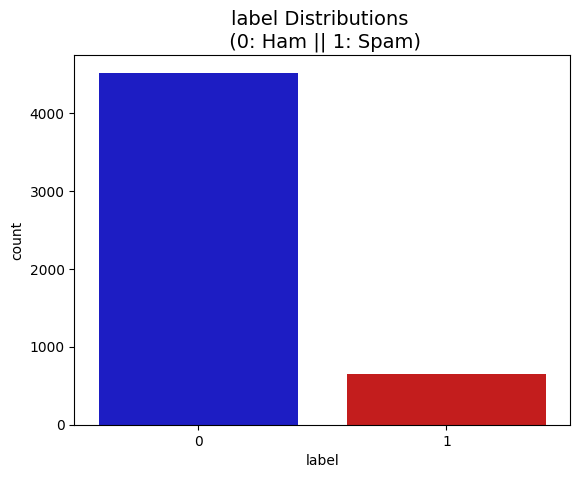

In [18]:
colors= ["#0101DF", "#DF0101"]
sns.countplot(x="label", data=df, palette=colors)
plt.title('label Distributions \n (0: Ham || 1: Spam)', fontsize=14)
plt.show()

In [19]:
df.head()

,label,message,length,punct
0,0,go until jurong point crazy available only in ...,111,9
1,0,ok lar joke wif u oni,29,6
2,1,free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,u dun say so early hor u c already then say,49,6
4,0,nah I do not think he go to usf he live around...,61,2


# *`MACHINE LEARNING`*

In [20]:
X = np.hstack((X_message.toarray(), df[['length', 'punct']].values))
y=df['label']


In [21]:
# since data is imbalance, use under sampling
from imblearn.under_sampling import NearMiss
model= NearMiss()
x_under_resampled, y_under_resampled = model.fit_resample(X, y)
x_under_resampled.shape, y_under_resampled.shape

((1306, 7768), (1306,))

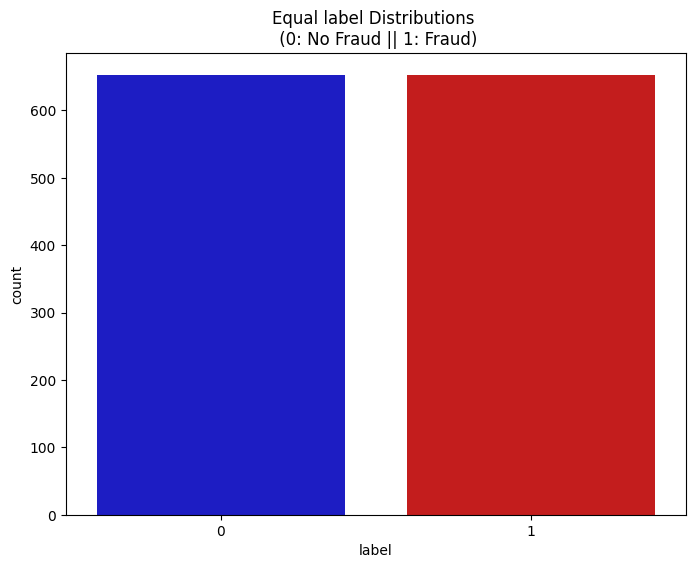

label
0   0.50
1   0.50
Name: count, dtype: float64


In [22]:

plt.figure(figsize = (8, 6))
colors= ["#0101DF", "#DF0101"]
sns.countplot(x = y_under_resampled, palette = colors)
plt.title("Equal label Distributions \n (0: No Fraud || 1: Fraud)")
plt.show()
print(y_under_resampled.value_counts()/len(y_under_resampled))

In [23]:
# Split the data into training and testing sets
#under sampling
x_train_under,x_test_under,y_train_under,y_test_under = train_test_split(x_under_resampled, y_under_resampled, test_size=0.25)



In [36]:
from sklearn.ensemble import ExtraTreesClassifier
model= ExtraTreesClassifier()
model.fit(x_train_under, y_train_under)
y_pred_under = model.predict(x_test_under)

In [37]:
#evaluation metrix
print(classification_report(y_test_under, y_pred_under))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       156
           1       1.00      0.95      0.97       171

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



In [38]:
confusion_matrix(y_test_under, y_pred_under)

array([[156,   0],
       [  9, 162]])

In [39]:
accuracy_score(y_test_under, y_pred_under)

0.9724770642201835

In [40]:
joblib.dump(model, 'ExtraTreesmodel.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [24]:
#under sampling(identifying best model)
clf= LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_under, predictions_under = clf.fit(x_train_under, x_test_under, y_train_under, y_test_under)
print(models_under)

 97%|█████████▋| 28/29 [01:36<00:03,  3.05s/it]

[LightGBM] [Info] Number of positive: 482, number of negative: 497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492339 -> initscore=-0.030646
[LightGBM] [Info] Start training from score -0.030646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [01:37<00:00,  3.37s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.97               0.97     0.97      0.97   
LogisticRegression                 0.96               0.96     0.96      0.96   
CalibratedClassifierCV             0.96               0.96     0.96      0.96   
RandomForestClassifier             0.96               0.96     0.96      0.96   
PassiveAggressiveClassifier        0.96               0.96     0.96      0.96   
RidgeClassifierCV                  0.96               0.96     0.96      0.96   
LinearSVC                          0.96               0.96     0.96      0.96   
BernoulliNB                        0.95               0.95     0.95      0.95   
AdaBoostClassifier                 0.95               0.95     0.95      0.95   
RidgeClassifier                    0.94               0.95     0.95      0.94   
XGBClassifier               